In [1]:
import numpy as np
import numpy.random as npr
npr.seed(12345)
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter
colors = ['r', 'b', 'y', 'g']
colors = [ColorConverter().to_rgb(c) for c in colors]

from pypolyagamma import TreeStructuredMultinomialRegression
from pypolyagamma.utils import gradient_cmap

In [2]:
def _plot_mult_probs(reg,
                     xlim=(-4,4), ylim=(-3,3), n_pts=100,
                     ax=None):
    XX,YY = np.meshgrid(np.linspace(*xlim,n_pts),
                        np.linspace(*ylim,n_pts))
    XY = np.column_stack((np.ravel(XX), np.ravel(YY)))

    D_reg = reg.D_in
    inputs = np.hstack((np.zeros((n_pts**2, D_reg-2)), XY))
    test_prs = reg.pi(inputs)

    if ax is None:
        fig = plt.figure(figsize=(10,6))
        ax = fig.add_subplot(111)

    for k in range(reg.K):
        start = np.array([1.0, 1.0, 1.0, 0.0])
        end = np.array(colors[k] + (0.5,))
        cmap = gradient_cmap([start, end])
        ax.imshow(test_prs[:,k].reshape(*XX.shape),
                  extent=xlim + tuple(reversed(ylim)),
                  vmin=0, vmax=1, cmap=cmap)

        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()
    return 

In [3]:
N = 1000
N_iter = 1000

In [4]:
### Construct multinomial regression to divvy up the space #
K, D_in = 4, 2
w1, b1 = np.array([+1.0, 0.0]), np.array([0.0])  # x + b < 0 -> x < -b
w2, b2 = np.array([0.0, +1.0]), np.array([0.0])  # y < 0
w3, b3 = np.array([0.0, -1.0]), np.array([0.0])  # y > 0

reg_W = np.row_stack([w1, w2, w3][:K-1])
reg_b = np.row_stack([b1, b2, b3][:K-1])

In [5]:
# Scale the weights to make the transition boundary sharper
reg_scale = 5.
reg_b *= reg_scale
reg_W *= reg_scale

# Account for stick breaking asymmetry
true_reg = TreeStructuredMultinomialRegression(1, K, D_in, A=reg_W, b=reg_b)

In [6]:
# Sample data from the model
mask = np.ones((N, K-1), dtype=bool)
X = np.random.randn(N,2).dot(np.diag([2,1]))
y_oh = true_reg.rvs(x=X).astype(np.float)
y = np.argmax(y_oh, axis=1)
usage = y_oh.sum(0)
print("Label usage: ", usage)

# Apply a permutation
# perm = np.random.permutation(K)
# perm = np.argsort(np.argsort(-usage))
perm = np.arange(K)
y_oh_perm = y_oh[:, perm]
y_perm = np.argmax(y_oh_perm, axis=1)

Label usage:  [275. 250. 246. 229.]


/home/fmorenovr/anaconda3/envs/polygam/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [7]:
# Create a test model for fitting
test_reg = TreeStructuredMultinomialRegression(1, K, D_in, sigmasq_A=10000., sigmasq_b=10000.)
for itr in range(N_iter):
    if itr % 100 == 0:
        print("Iter: {}".format(itr))
    test_reg.resample(data=[(X, y_oh_perm[:, :-1])], mask=[mask])

np.set_printoptions(precision=3)
print("True A:\n{}".format(true_reg.A))
print("True b:\n{}".format(true_reg.b))
print("Test A:\n{}".format(test_reg.A))
print("Test b:\n{}".format(test_reg.b))

Iter: 0
Iter: 100
Iter: 200
Iter: 300
Iter: 400
Iter: 500
Iter: 600
Iter: 700
Iter: 800
Iter: 900
True A:
[[ 5.  0.]
 [ 0.  5.]
 [ 0. -5.]]
True b:
[[0.]
 [0.]
 [0.]]
Test A:
[[ 4.276 -0.3  ]
 [-0.093  5.642]
 [ 0.188 -5.966]]
Test b:
[[ 0.16 ]
 [ 0.507]
 [-0.014]]


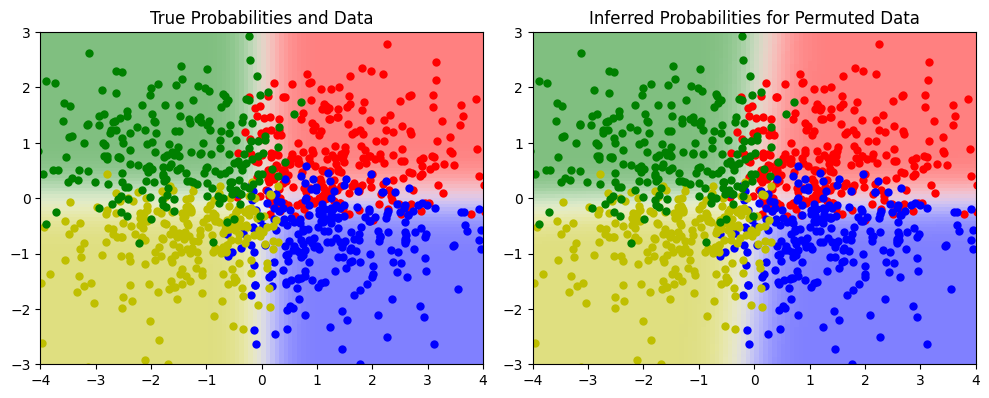

In [8]:
# Plot the results
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
_plot_mult_probs(true_reg, ax=ax1)
for k in range(K):
    ax1.plot(X[y==k, 0], X[y==k, 1], 'o', color=colors[k], markeredgecolor="none")
ax1.set_title("True Probabilities and Data")

ax2 = fig.add_subplot(122)
_plot_mult_probs(test_reg, ax=ax2)
for k in range(K):
    ax2.plot(X[y_perm == k, 0], X[y_perm == k, 1], 'o', color=colors[k], markeredgecolor="none")
ax2.set_title("Inferred Probabilities for Permuted Data")
plt.show()